In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# Flash Unit Model Tutorial

Author: Jaffer Ghouse<br>
Maintainer: Tanner Polley<br>
Updated: 2025-06-03

In this module, we will familiarize ourselves with the IDAES framework by creating and working with a flowsheet that contains a single flash tank. The flash tank will be used to perform separation of Benzene and Toluene.

The general workflow of setting up an IDAES flowsheet is the following:

- 1 Importing Modules
- 2 Building a Model
- 3 Scaling the Model
- 4 Specifying the Model
- 5 Initializing the Model
- 6 Solving the Model
- 7 Analyzing and Visualizing the Results

We will complete each of these steps as well as demonstrate analyses on this model through some examples and exercises

## Key links to documentation
* Main IDAES online documentation page: https://idaes-pse.readthedocs.io/en/stable/
* General Workflow: https://idaes-pse.readthedocs.io/en/stable/how_to_guides/workflow/general.html
* Flash Unit Model Documentation: https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/unit_models/flash.html



## 1 Import Modules

In the next cell, we will perform the necessary imports to get us started. From `pyomo.environ` (a standard import for the Pyomo package), we are importing `ConcreteModel` (to create the Pyomo model that will contain the IDAES flowsheet) and `SolverFactory` (to create the object we will use to solve the equations). We will also import `Constraint` as we will be adding a constraint to the model later in the module. Lastly, we also import `value` from Pyomo. This is a function that can be used to return the current numerical value for variables and parameters in the model. These are all part of Pyomo.

We will also import the main `FlowsheetBlock` from IDAES. The flowsheet block will contain our unit model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below to perform the imports. Let a workshop organizer know if you see any errors.
</div>

In [2]:
from pyomo.environ import ConcreteModel, SolverFactory, Constraint, value
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

%matplotlib inline

## 2 Create the Model and IDAES Flowsheet

In the next cell, we will create the `ConcreteModel` object often named `m` (which comes from Pyomo) and then connect the `FlowsheetBlock` (which comes from IDAES) to `m`. We ensure `dynamic=False` since this is a steady-state problem. This creates our overall model and adds the flowsheet capabilities that IDAES provides to the Pyomo model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below to create the objects
</div>

In [3]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

In [5]:
# Todo: call pprint on the model
m.pprint()

1 Block Declarations
    fs : Size=1, Index=None, Active=True
        1 Set Declarations
            _time : Size=1, Index=None, Ordered=Insertion
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    1 :  {0.0,}

        1 Declarations: _time

1 Declarations: fs


### 2.1 Define Properties

We need to define the property package for our flowsheet. In this example, we will be using the ideal property package that is available as part of the IDAES framework. This property package supports ideal gas - ideal liquid, ideal gas - NRTL, and ideal gas - Wilson models for VLE. More details on this property package can be found at: https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/property_models/activity_coefficient.html

IDAES also supports creation of your own property packages that will be shown in a later module.

For this workshop, we will import the BTX_activity_coeff_VLE property parameter block to be used in the flowsheet. This properties block will be passed to our unit model to define the appropriate state variables and equations for performing thermodynamic calculations.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the following two cells to import and create the properties block.
</div>

In [6]:
from idaes.models.properties.activity_coeff_models.BTX_activity_coeff_VLE import (
    BTXParameterBlock,
)

In [7]:
m.fs.properties = BTXParameterBlock(
    valid_phase=("Liq", "Vap"), activity_coeff_model="Ideal", state_vars="FTPz"
)

### 2.2 Adding Flash Unit

Now that we have the flowsheet and the properties defined, we can create the flash unit and add it to the flowsheet.

**The Unit Model Library within IDAES includes a large set of common unit operations (see the online documentation for details: https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/unit_models/index.html**

IDAES also fully supports the development of customized unit models (which we will see in a later module).

Some of the IDAES pre-written unit models:
* Mixer / Splitter
* Heater / Cooler
* Heat Exchangers (simple and 1D discretized)
* Flash
* Reactors (kinetic, equilibrium, gibbs, stoichiometric conversion)
* Pressure changing equipment (compressors, expanders, pumps)
* Feed and Product (source / sink) components

In this module, we will import the `Flash` unit model from `idaes.models.unit_models` and create an instance of the flash unit, attaching it to the flowsheet. Each IDAES unit model has several configurable options to customize the model behavior, but also includes defaults for these options. In this example, we will specify that the property package to be used with the Flash unit model is the one we created earlier by setting `property_package=m.fs.properties` within the `Flash` method.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the following two cells to import the Flash and create an instance of the unit model, attaching it to the flowsheet object.
</div>

In [8]:
from idaes.models.unit_models import Flash

In [9]:
m.fs.flash = Flash(property_package=m.fs.properties)

At this point, we have created a flowsheet and a properties block. We have also created a flash unit and added it to the flowsheet. Under the hood, IDAES has created the required state variables and model equations. Everything is open. You can see these variables and equations by calling the Pyomo method `pprint` on the model, flowsheet, or flash tank objects. Note that this output is very exhaustive, and is not intended to provide any summary information about the model, but rather a complete picture of all of the variables and equations in the model.

## 3 Scaling the Model

Now that the model is built, with properties set and the unit model created and added to the flowsheet, the next step is to scale the model. Ensuring that a model is well scaled is important for increasing the efficiency and reliability of solvers, and users should consider model scaling as an integral part of the modeling process. IDAES provides a number of tool for assisting users with scaling their models, and details on these can be found at https://idaes-pse.readthedocs.io/en/stable/reference_guides/scaling/scaling.html#scaling-toolbox

There are currently two primary methods in scaling the model: manual scaling of each relevant component, or utilizing the AutoScaler Class. The more careful and risk-free method of manually scaling each component is the recommended method for maximum control and assurance that the model will be well-scaled. This comes with the drawback of being more meticulous while the AutoScaler is much simpler to use since it scaled the whole model all at once, it is less precise by lacking direct control over the scaling factor for each component and relying on scaling factors to be estimated. Both methods will be shown below

### 3.1 Manual Scaling
The `set_scaling_factor` function is imported from `idaes.core.scaling.util` and is called with and used on each relevant component that needs to be well scaled. The component is the first argument and its scaling factor is the second argument.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the following two cells to import the `set_scaling_factor` and set the scaling factor for both temperature and pressure
</div>

Both `temperature` and `pressure` can be found at `m.fs.flash.inlet`.

In [11]:
from idaes.core.scaling.util import set_scaling_factor

In [12]:
set_scaling_factor(m.fs.flash.inlet.temperature, 300)
set_scaling_factor(m.fs.flash.inlet.pressure, 1e6)

### 3.2 Scaling with AutoScaler
The `AutoScaler` class is imported from `idaes.core.scaling.autoscaling` and an instance of the class is created. This instance contains the method `scale_model` which is used to scale the whole model at once. This can be a useful option but is generally more risky than manually scaling the model components since it has less direct control and specification.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the following two cells to import the `AutoScaler` class and create an autoscaler instance that scaled the whole model at once
</div>

In [13]:
from idaes.core.scaling.autoscaling import AutoScaler

In [14]:
autoscaler = AutoScaler()
autoscaler.scale_model(m)

## 4 Set Operating Conditions

Now that we have created our unit model and scaled it, we can specify the necessary operating conditions. The inlet specifications for this flash tank are:

Inlet Specifications:
* Mole fraction (Benzene) = 0.5
* Mole fraction (Toluene) = 0.5
* Pressure = 101325 Pa
* Temperature = 368 K




### 4.1 Degrees of Freedom

It is often very useful to first determine the degrees of freedom before we specify any conditions.

The `idaes.core.util.model_statistics` package has a function `degrees_of_freedom`. To see how to use this function, we can make use of the Python function `help(func)`. This function prints the appropriate documentation string for the function.


In [16]:
# Todo: import the degrees_of_freedom function from the idaes.core.util.model_statistics package
from idaes.core.util.model_statistics import degrees_of_freedom

# Todo: Call the python help on the degrees_of_freedom function
help(degrees_of_freedom)

Help on function degrees_of_freedom in module idaes.core.util.model_statistics:

degrees_of_freedom(block)
    Method to return the degrees of freedom of a model.

    Args:
        block : model to be studied

    Returns:
        Number of degrees of freedom in block.



In [18]:
# Todo: print the degrees of freedom for your model
print("Degrees of Freedom =", degrees_of_freedom(m))

Degrees of Freedom = 7


In [19]:
# Check the degrees of freedom
assert degrees_of_freedom(m) == 7

### 4.2 Specify Inlet Conditions

To satisfy our degrees of freedom, we will first specify the inlet conditions. We can specify these values through the `inlet` port of the flash unit.

**To see the list of naming conventions for variables within the IDAES framework, consult the online documentation at: https://idaes-pse.readthedocs.io/en/stable/explanations/conventions.html#standard-naming-format**

As an  example, to fix the molar flow of the inlet to be 1.0, you can use the following notation:
```python
m.fs.flash.inlet.flow_mol.fix(1.0)
```

To specify variables that are indexed by components, you can use the following notation:
```python
m.fs.flash.inlet.mole_frac_comp[0, "benzene"].fix(0.5)
```

<div class="alert alert-block alert-warning">
<b>Note:</b>
The "0" in the indexing of the component mole fraction is present because IDAES models support both dynamic and steady state simulation, and the "0" refers to a timestep. Dynamic modeling is beyond the scope of this workshop. Since we are performing steady state modeling, there is only a single timestep in the model.
</div>

In the next cell, we will specify the inlet conditions. To satisfy the remaining degrees of freedom, we will make two additional specifications on the flash tank itself. The names of the key variables within the Flash unit model can also be found in the online documentation: https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/unit_models/flash.html#variables.


To specify the value of a variable on the unit itself, use the following notation.

```python
m.fs.flash.heat_duty.fix(0)
```

For this module, we will use the following specifications:
* inlet overall molar flow = 1.0 (`flow_mol`)
* inlet temperature = 368 K (`temperature`)
* inlet pressure = 101325 Pa (`pressure`)
* inlet mole fraction (benzene) = 0.5 (`mole_frac_comp[0, "benzene"]`)
* inlet mole fraction (toluene) = 0.5 (`mole_frac_comp[0, "toluene"]`)
* The heat duty on the flash set to 0 (`heat_duty`)
* The pressure drop across the flash tank set to 0 (`deltaP`)



In [21]:
# Todo: Add inlet specifications given above
m.fs.flash.inlet.flow_mol.fix(1)
m.fs.flash.inlet.temperature.fix(368)
m.fs.flash.inlet.pressure.fix(101325)
m.fs.flash.inlet.mole_frac_comp[0, "benzene"].fix(0.5)
m.fs.flash.inlet.mole_frac_comp[0, "toluene"].fix(0.5)

# Todo: Add 2 flash unit specifications given above
m.fs.flash.heat_duty.fix(0)
m.fs.flash.deltaP.fix(0)

Now that all the inlets have been specified, we can check the degrees of freedom again to ensure the system is square and has a degree of freedom of 0



In [23]:
# Todo: print the degrees of freedom for your model
print("Degrees of Freedom =", degrees_of_freedom(m))

Degrees of Freedom = 0


In [24]:
# Check the degrees of freedom
assert degrees_of_freedom(m) == 0

## 5 Initializing the Model

Now that all building steps are complete, the last step before solving the model is to initialize the model, or prepping the solve by giving it a good starting point. This is essentially giving the solver an initial guess for the iterative solver to reach convergence and is essential for both a fast and accurate solution. In IDAES, the current standard for initializing the model is by utilizing initializer instances. These initializer instances contain the initialize method that can be applied to any model type. For more information on initializing in IDAES, visit https://idaes-pse.readthedocs.io/en/stable/reference_guides/initialization/index.html. <br>

For this tutorial, we will import the initializer class `BlockTriangularizationInitializer` class from the `default_initializer` method from the flash unit model. This is often the simplest way to obtain a compatible initializer for each unit model, but you can also directly important any initializer needed from this source `idaes.core.initialization`. Each initializer instance contains the `initialize()` method that requires an argument to be initialized and in this case its the flash unit model.


In [33]:
# Todo: initialize the flash unit
FlashInitializer = m.fs.flash.default_initializer()
FlashInitializer.initialize(m.fs.flash)

2025-06-06 10:51:39 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 1 optimal - <undefined>.
2025-06-06 10:51:39 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 2 optimal - <undefined>.
2025-06-06 10:51:39 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 3 optimal - <undefined>.
2025-06-06 10:51:39 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 4 optimal - <undefined>.
2025-06-06 10:51:39 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 5 optimal - <undefined>.
2025-06-06 10:51:40 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 1 optimal - <undefined>.
2025-06-06 10:51:40 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 2 optimal - <undefined>.
2025-06-06 10:51:40 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 3 optimal - <undefined>.
2025-06-06 10:51:40 [

<InitializationStatus.Ok: 1>

Another option for initializing is utilizing the default initializer that is attached to the unit model. Each unit model as a default initializer that is hypothetically the most compatible. It can be called with `m.fs.flash.initialize()`. While this is an option, it is generally preferred to import an initializer object and initialize the model with that to ensure more control over the initialization.

## 6 Solving the Model

Now that the model has been defined and initialized, we can solve the model.



In [37]:
# Todo: create the ipopt solver
solver = SolverFactory("ipopt")

# Todo: solve the model
status = solver.solve(m, tee=True)

component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of F

In [38]:
# Check for an optimal solution
from pyomo.environ import TerminationCondition

assert status.solver.termination_condition == TerminationCondition.optimal

## 7 Viewing the Results

Once a model is solved, the values returned by the solver are loaded into the model object itself. We can access the value of any variable in the model with the `value` function. For example:
```python
print('Vap. Outlet Temperature = ', value(m.fs.flash.vap_outlet.temperature[0]))
```

You can also find more information about a variable or an entire port using the `display` method from Pyomo:
```python
m.fs.flash.vap_outlet.temperature.display()
m.fs.flash.vap_outlet.display()
```

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cells below to show the current value of the flash vapor outlet pressure. This cell also shows use of the display function to see the values of the variables in the vap_outlet and the liq_outlet.
</div>

In [39]:
# Print the pressure of the flash vapor outlet
print("Pressure =", value(m.fs.flash.vap_outlet.pressure[0]))

print()
print("Output from display:")
# Call display on vap_outlet and liq_outlet of the flash
m.fs.flash.vap_outlet.display()
m.fs.flash.liq_outlet.display()

Pressure = 101325.0

Output from display:
vap_outlet : Size=1
    Key  : Name           : Value
    None :       flow_mol : {0.0: 0.3961181748774193}
         : mole_frac_comp : {(0.0, 'benzene'): 0.633976648508129, (0.0, 'toluene'): 0.366023351491871}
         :       pressure : {0.0: 101325.0}
         :    temperature : {0.0: 368.0}
liq_outlet : Size=1
    Key  : Name           : Value
    None :       flow_mol : {0.0: 0.6038818251225807}
         : mole_frac_comp : {(0.0, 'benzene'): 0.41211759772293044, (0.0, 'toluene'): 0.5878824022770694}
         :       pressure : {0.0: 101325.0}
         :    temperature : {0.0: 368.0}


The output from `display` is quite exhaustive and not really intended to provide quick summary information. Because Pyomo is built on Python, there are opportunities to format the output any way we like. Most IDAES models have a `report` method which provides a summary of the results for the model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below which uses the function above to print a summary of the key variables in the flash model, including the inlet, the vapor, and the liquid ports.
</div>

In [40]:
m.fs.flash.report()


Unit : fs.flash                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Units  : Fixed : Bounds
          Heat Duty : 0.0000 :   watt :  True : (None, None)
    Pressure Change : 0.0000 : pascal :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Units         Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                mole / second     1.0000      0.39612       0.60388  
    mole_frac_comp benzene  dimensionless    0.50000      0.63398       0.41212  
    mole_frac_comp toluene  dimensionless    0.50000      0.36602       0.58788  
    temperature                    kelvin     368.00       368.00        368.00  
    pressure                       pascal 1.0132e+05   1.0132e+05    1.0132e+05  


In [41]:
# Check optimal solution values
import pytest

assert value(m.fs.flash.liq_outlet.flow_mol[0]) == pytest.approx(0.6038, abs=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, "benzene"]) == pytest.approx(
    0.4121, abs=1e-3
)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, "toluene"]) == pytest.approx(
    0.5878, abs=1e-3
)
assert value(m.fs.flash.liq_outlet.temperature[0]) == pytest.approx(368, abs=1e-3)
assert value(m.fs.flash.liq_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)

assert value(m.fs.flash.vap_outlet.flow_mol[0]) == pytest.approx(0.3961, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]) == pytest.approx(
    0.6339, abs=1e-3
)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, "toluene"]) == pytest.approx(
    0.3660, abs=1e-3
)
assert value(m.fs.flash.vap_outlet.temperature[0]) == pytest.approx(368, abs=1e-3)
assert value(m.fs.flash.vap_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)

## Exercise: Studying Purity as a Function of Heat Duty

Since the entire modeling framework is built upon Python, it includes a complete programming environment for whatever analysis we may want to perform. In this next exercise, we will make use of what we learned in this and the previous module to generate a figure showing some output variables as a function of the heat duty in the flash tank.

First, let's import the matplotlib package for plotting as we did in the previous module.
<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below to import matplotlib appropriately.
</div>

In [42]:
import matplotlib.pyplot as plt

Exercise specifications:
* Generate a figure showing the flash tank heat duty (`m.fs.flash.heat_duty[0]`) vs. the vapor flowrate (`m.fs.flash.vap_outlet.flow_mol[0]`)
* Specify the heat duty from -17000 to 25000 over 50 steps



2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 1 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 2 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 3 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 4 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 5 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 1 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 2 optimal - <undefined>.
2025-06-06 11:04:46 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 3 optimal - <undefined>.
2025-06-06 11:04:46 [

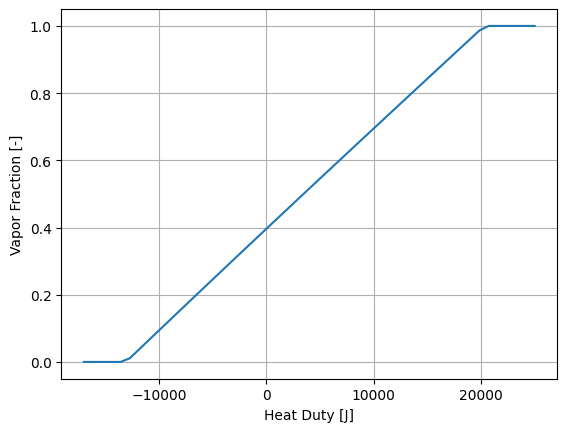

In [43]:
# import the solve_successful checking function from workshop tools
from idaes_examples.mod.tut.workshoptools import solve_successful

# Todo: import numpy
import numpy as np

# create the empty lists to store the results that will be plotted
Q = []
V = []

# re-initialize model
FlashInitializer.initialize(m.fs.flash)

# Todo: Write the for loop specification using numpy's linspace
for duty in np.linspace(-17000, 25000, 50):
    # fix the heat duty
    m.fs.flash.heat_duty.fix(duty)

    # append the value of the duty to the Q list
    Q.append(duty)

    # print the current simulation
    print("Simulating with Q = ", value(m.fs.flash.heat_duty[0]))

    # Solve the model
    status = solver.solve(m)

    # append the value for vapor fraction if the solve was successful
    if solve_successful(status):
        V.append(value(m.fs.flash.vap_outlet.flow_mol[0]))
        print("... solve successful.")
    else:
        V.append(0.0)
        print("... solve failed.")

# Create and show the figure
plt.figure("Vapor Fraction")
plt.plot(Q, V)
plt.grid()
plt.xlabel("Heat Duty [J]")
plt.ylabel("Vapor Fraction [-]")
plt.show()

Simulating with Q =  -17000.0
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -16142.857142857143
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -15285.714285714286
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -14428.571428571428
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -13571.428571428572
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -12714.285714285714
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -11857.142857142857
component keys that are not exported as part of the NL file.  Skipping.
... solve successful.
Simulating with Q =  -11000.0
component keys that are not exported

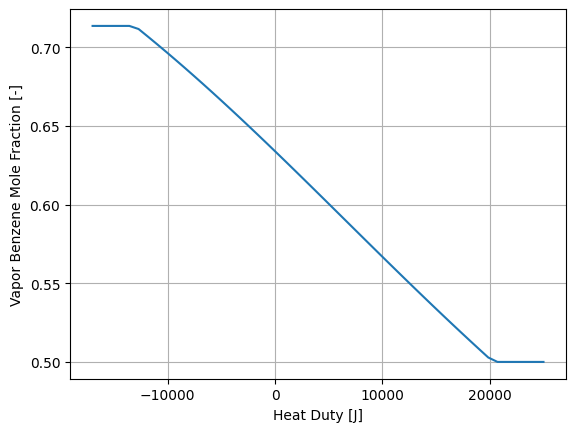

In [44]:
# Todo: generate a figure of heat duty vs. mole fraction of Benzene in the vapor
Q = []
V = []

for duty in np.linspace(-17000, 25000, 50):
    # fix the heat duty
    m.fs.flash.heat_duty.fix(duty)

    # append the value of the duty to the Q list
    Q.append(duty)

    # print the current simulation
    print("Simulating with Q = ", value(m.fs.flash.heat_duty[0]))

    # solve the model
    status = solver.solve(m)

    # append the value for vapor fraction if the solve was successful
    if solve_successful(status):
        V.append(value(m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]))
        print("... solve successful.")
    else:
        V.append(0.0)
        print("... solve failed.")

plt.figure("Purity")
plt.plot(Q, V)
plt.grid()
plt.xlabel("Heat Duty [J]")
plt.ylabel("Vapor Benzene Mole Fraction [-]")
plt.show()

Recall that the IDAES framework is an equation-oriented modeling environment. This means that we can specify "design" problems natively. That is, there is no need to have our specifications on the inlet alone. We can put specifications on the outlet as long as we retain a well-posed, square system of equations.

For example, we can remove the specification on heat duty and instead specify that we want the mole fraction of Benzene in the vapor outlet to be equal to 0.6. The mole fraction is not a native variable in the property block, so we cannot use "fix". We can, however, add a constraint to the model.

Note that we have been executing a number of solves on the problem, and may not be sure of the current state. To help convergence, therefore, we will first call initialize, then add the new constraint and solve the problem. Note that the reference for the mole fraction of Benzene in the vapor outlet is `m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]`.



In [46]:
# re-initialize the model - this may or may not be required depending on current state but safe to initialize
m.fs.flash.heat_duty.fix(0)
m.fs.flash.initialize(outlvl=idaeslog.WARNING)

# Unfix the heat_duty variable
m.fs.flash.heat_duty.unfix()

# Todo: Add a new constraint (benzene mole fraction to 0.6)
m.benz_purity_con = Constraint(
    expr=m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"] == 0.6
)

# solve the problem
status = solver.solve(m, tee=True)

# Check stream condition
m.fs.flash.report()

component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of F

In [ ]:
# Check for solver status
assert status.solver.termination_condition == TerminationCondition.optimal

# Check for optimal values
assert value(m.fs.flash.liq_outlet.flow_mol[0]) == pytest.approx(0.4516, abs=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, "benzene"]) == pytest.approx(
    0.3786, abs=1e-3
)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, "toluene"]) == pytest.approx(
    0.6214, abs=1e-3
)
assert value(m.fs.flash.liq_outlet.temperature[0]) == pytest.approx(369.07, abs=1e-2)
assert value(m.fs.flash.liq_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)

assert value(m.fs.flash.vap_outlet.flow_mol[0]) == pytest.approx(0.5483, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]) == pytest.approx(
    0.6, abs=1e-3
)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, "toluene"]) == pytest.approx(
    0.4, abs=1e-3
)
assert value(m.fs.flash.vap_outlet.temperature[0]) == pytest.approx(369.07, abs=1e-2)
assert value(m.fs.flash.vap_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)